In [45]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
%matplotlib inline

In [3]:
words = open("names.txt").read().splitlines()

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [6]:
# build the dataset
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [46]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [93]:
g = torch.Generator().manual_seed(2147483647)

emb_size = 10
layer1 = 250

# embedding 
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((block_size * emb_size, layer1), generator=g)
b1 = torch.randn(layer1, generator=g)
W2 = torch.randn((layer1, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [94]:
sum(p.nelement() for p in parameters) # num of parameters

14797

In [56]:
lre = torch.linspace(-3, 0, 1000) # exponents of 10. (from 0.001 to 1)
lrs = 10**lre 
lr = 0.1

In [95]:
"""
On a single batch it's impossible to achieve 0 loss because the start of a name is different for each name.
When the model sees the start "..." it has different starting letters that can be used.
"""
lri = []
lossi = [] 
stepi = []
# lr = 0.01
for i in range(200_000):
    # take a minibatch
    ix = torch.randint(0, Xtr.shape[0], (64,))

    # forward pass 
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1  + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.7737034559249878


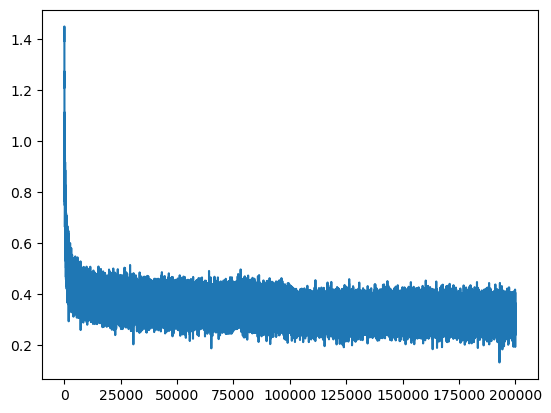

In [96]:
plt.plot(stepi, lossi)

In [97]:
# check loss on train test
emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1  + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1193, grad_fn=<NllLossBackward0>)

In [98]:
# check loss on valid test
emb = C[Xval]
h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1  + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

# achieved 2.1681 with 2 modifications: augment from 200 to 250 the layer size and batchsize from 32 to 64.

tensor(2.1681, grad_fn=<NllLossBackward0>)

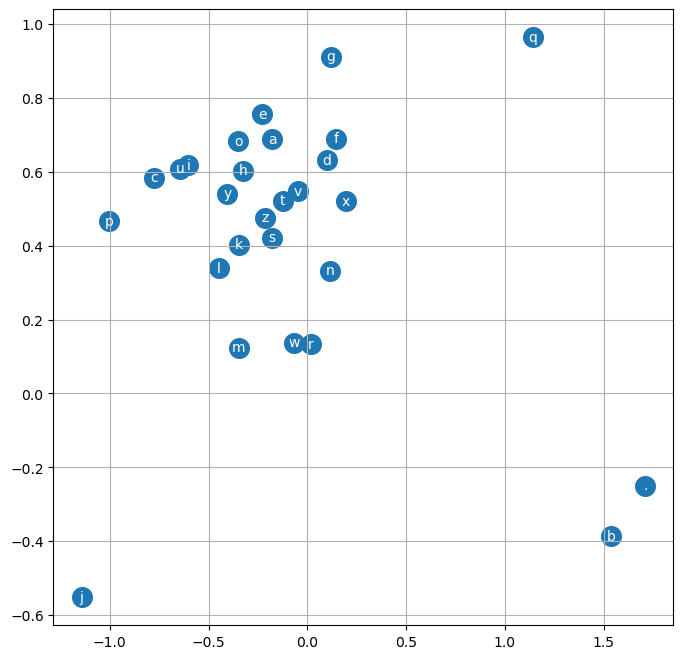

In [99]:
# visualize embeddings 
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center",  color="white")
plt.grid("minor")

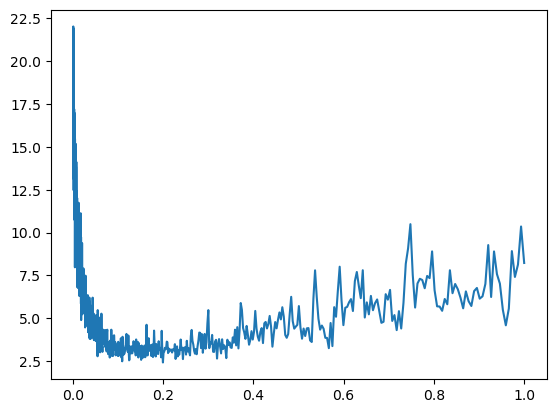

In [31]:
# lr, loss
plt.plot(lri, lossi)

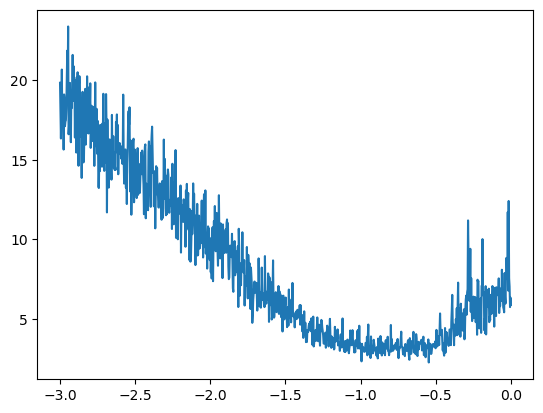

In [36]:
# lr exponent, loss
# 10**-1 seems a good lr 
plt.plot(lri, lossi)